In [1]:
from os import path
import os
import pickle

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from pyia import GaiaData

import gala.coordinates as gc
import gala.dynamics as gd
from scipy.stats import binned_statistic
from scipy.special import logsumexp
from scipy.optimize import minimize

import emcee

In [2]:
plot_path = 'stream-probs/plots'
os.makedirs(plot_path, exist_ok=True)

In [3]:
phi2_poly = np.poly1d(np.load('../output/polytrack.npy'))

In [4]:
g = GaiaData('../data/gd1-with-masks.fits')
stream = g[g.pm_mask & g.gi_cmd_mask]

In [5]:
phi1 = stream.phi1
phi2 = stream.phi2
pm1 = stream.pm_phi1_cosphi2
pm2 = stream.pm_phi2

(-10, 5)

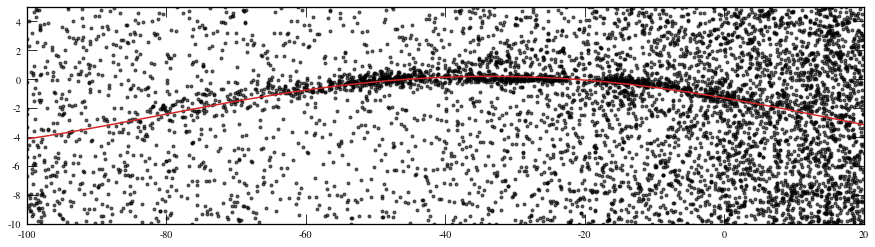

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

ax.plot(phi1, phi2, 
        marker='o', linewidth=0, ms=3,
        linestyle='none', alpha=0.6, c='k')

phi1_grid = np.linspace(-100, 20, 256)
ax.plot(phi1_grid, phi2_poly(phi1_grid), marker='', color='tab:red')

ax.set_xlim(-100, 20)
ax.set_ylim(-10, 5)

In [7]:
phi2_max = 5.
phi2_min = -7.5

In [8]:
def lnnormal(x, mu, std):
    return -0.5 * (x-mu)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

def lnprior(p):
    (lna_s1, lna_s2, lna_f1, lna_f2, 
     mu_s, lnstd_s1, lnstd_s2, 
     mu_f1, lnstd_f1,
     mu_f2, lnstd_f2) = p
    
    (a_s1, a_s2, a_f1, a_f2) = np.exp([lna_s1, lna_s2, lna_f1, lna_f2])
    
    lp = 0
    
    fs = [a_f1, a_f2, a_s1, a_s2]
    for f in fs:
        if f < 0 or f > 1:
            return -np.inf
    
    if a_s2 > a_s1 or a_f1 > (a_s1+a_s2) or a_f2 > (a_s1+a_s2):
        return -np.inf
    
    if sum(fs) > 1:
        return -np.inf
    
    for mu in [mu_s, mu_f1, mu_f2]:
        if mu < -7.5 or mu > 4:
            return -np.inf
    
    # keep feature 1 on left, feature 2 on right
    if mu_f1 > mu_s or mu_f2 < mu_s:
        return -np.inf
    
    lp += lnnormal(lna_f1, -1, 2)
    lp += lnnormal(lna_f2, -1, 2)
    lp += lnnormal(lna_s1, -1, 2)
    lp += lnnormal(lna_s2, -1, 2)
    
    lp += lnnormal(lnstd_f1, -1, 0.5)
    lp += lnnormal(lnstd_f2, -1, 0.5)
    lp += lnnormal(lnstd_s1, -1, 0.5)
    lp += lnnormal(lnstd_s2, -1, 0.5)
    
    return lp

def lnlike(p, phi2):
    (lna_s1, lna_s2, lna_f1, lna_f2, 
     mu_s, lnstd_s1, lnstd_s2, 
     mu_f1, lnstd_f1,
     mu_f2, lnstd_f2) = p
    
    (a_s1, a_s2, a_f1, a_f2) = np.exp([lna_s1, lna_s2, lna_f1, lna_f2])    
    a_bg = 1 - a_f1 - a_f2 - a_s1 - a_s2
    
    gd1 = lnnormal(phi2, mu_s, np.exp(lnstd_s1)) + lna_s1
    gd1_2 = lnnormal(phi2, mu_s, np.exp(lnstd_s2)) + lna_s2
    feat1 = lnnormal(phi2, mu_f1, np.exp(lnstd_f1)) + lna_f1
    feat2 = lnnormal(phi2, mu_f2, np.exp(lnstd_f2)) + lna_f2
    bg = np.full_like(gd1, -np.log(phi2_max - phi2_min)) + np.log(a_bg)
    
    args = [gd1, gd1_2, feat1, feat2, bg]    
    return logsumexp(args, axis=0), args

def lnprob(p, phi2):
    lp = lnprior(p)
    if not np.all(np.isfinite(lp)):
        return -np.inf, None
    
    ll, *args = lnlike(p, phi2)
    if not np.all(np.isfinite(ll)):
        return -np.inf, None
    
    return ll.sum() + lp, args

In [9]:
names = [r'$\ln\alpha_{s, 1}$', r'$\ln\alpha_{s, 2}$', 
         r'$\ln\alpha_{f, 1}$', r'$\ln\alpha_{f, 2}$', 
         r'$\mu_s$', r'$\ln\sigma_{s, 1}$', r'$\ln\sigma_{s, 2}$',
         r'$\mu_{f, 1}$', r'$\ln\sigma_{f, 1}$',
         r'$\mu_{f, 2}$', r'$\ln\sigma_{f, 2}$']

In [10]:
bin_size = 6
phi1_bins_l = np.arange(-100, 20-bin_size+1e-3, bin_size)
phi2_bins = np.arange(phi2_min, phi2_max+1e-3, 0.2)

phi2_grid = np.linspace(phi2_min, phi2_max, 256)

In [11]:
results = []
p0s = []
for l in phi1_bins_l:
    r = l+bin_size
    phi_mask = ((phi1.value > l) & (phi1.value <= r) & 
                (phi2.value > -7.5))
    
    mu_s = phi2_poly(np.mean(phi1[phi_mask].value))
    mu_f1 = mu_s - 1.
    mu_f2 = mu_s + 1.
    
    p0 = (np.log(0.4), np.log(0.1), np.log(0.1), np.log(0.1), 
          mu_s, np.log(0.2), np.log(0.3), 
          mu_f1, np.log(0.15),
          mu_f2, np.log(0.15))  
    p0s.append(p0)
    
    res = minimize(lambda *args: -lnprob(*args)[0], x0=p0, 
                   args=(phi2.value[phi_mask], ), method='L-BFGS-B')
    
    if res.success:
        results.append(res.x)
    else:
        print('failed')
        results.append(np.full_like(p0, np.nan))
        
# fig, ax = plt.subplots()
# ax.hist(phi2[phi_mask],
#         bins=phi2_bins, alpha=1, normed=True);

# ax.plot(phi2_grid, np.exp(lnlike(p0, phi2_grid)[0]), 
#         color='tab:green', marker='', alpha=0.6)
# ax.plot(phi2_grid, np.exp(lnlike(res.x, phi2_grid)[0]), 
#         color='tab:red', marker='', alpha=0.6)

results = np.array(results)
p0s = np.array(p0s)

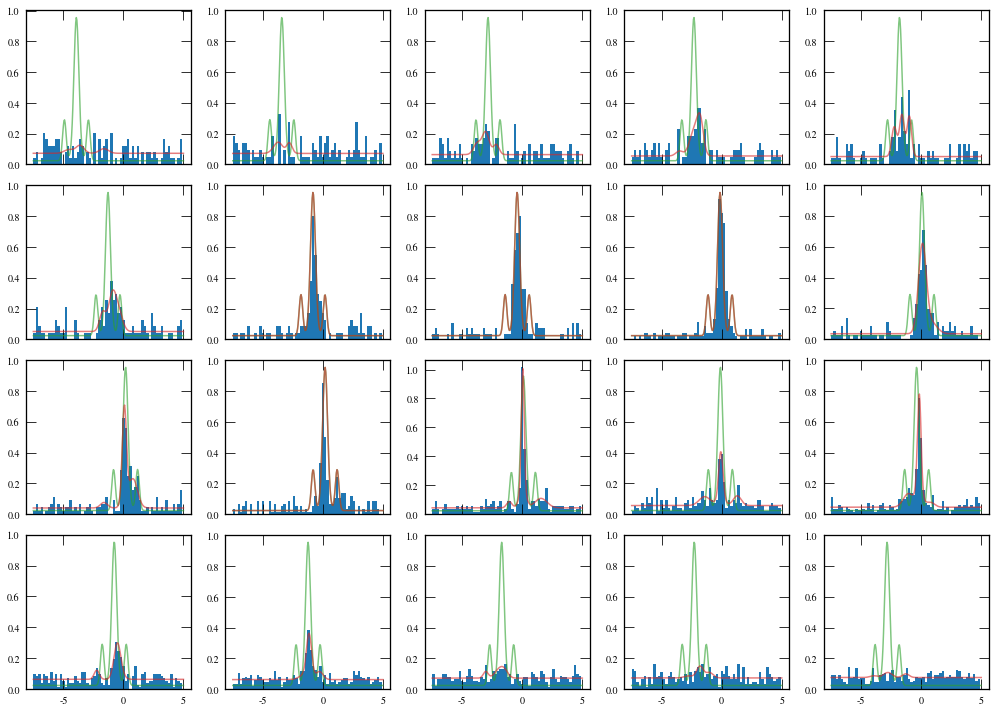

In [12]:
fig, axes = plt.subplots(4, 5, figsize=(14, 10), sharex=True)

for i, l in enumerate(phi1_bins_l):
    ax = axes.flat[i]
    
    r = l+bin_size
    phi_mask = ((phi1.value > l) & (phi1.value <= r) & 
                (phi2.value > -7.5))
    
    
    ax.hist(phi2[phi_mask],
            bins=phi2_bins, alpha=1, normed=True);
    
    p0 = p0s[i]
    res = results[i]
    ax.plot(phi2_grid, np.exp(lnlike(p0, phi2_grid)[0]), 
            color='tab:green', marker='', alpha=0.6)
    ax.plot(phi2_grid, np.exp(lnlike(res, phi2_grid)[0]), 
            color='tab:red', marker='', alpha=0.6)
    
fig.tight_layout()

In [13]:
def run_emcee(phi2, p0_mean, nwalkers=256, nburn=1024, nsteps=1024):
    p0 = emcee.utils.sample_ball(p0_mean, [1e-3, 1e-3, 1e-3, 1e-3,
                                           1e-1, 1e-3, 1e-3,
                                           1e-1, 1e-3,
                                           1e-1, 1e-3], nwalkers)
    
    sampler = emcee.EnsembleSampler(nwalkers, p0.shape[1], 
                                    lnpostfn=lnprob, 
                                    args=(phi2, ))
    pos, *_ = sampler.run_mcmc(p0, nburn)
    sampler.reset()
    _ = sampler.run_mcmc(pos, nsteps)
    
    return sampler

def get_stream_prob(sampler, phi_mask):
    norm = 0.0
    post_prob = np.zeros(phi_mask.sum())
    for i in range(sampler.chain.shape[1]):
        for j in range(sampler.chain.shape[0]):
            *ll_fg, ll_bg = sampler.blobs[i][j][0]
            ll_fg = logsumexp(ll_fg, axis=0)
            post_prob += np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))
            norm += 1
    post_prob /= norm
    
    return post_prob

In [14]:
plot = False

# all_samplers = []
phi_masks = []
stream_probs = []
for i, l in enumerate(phi1_bins_l):       
    sampler_file = path.join('stream-probs', '{}.pickle'.format(i))
    r = l+bin_size
    phi_mask = ((phi1.value > l) & (phi1.value <= r) & 
                (phi2.value > -7.5))
    
    if path.exists(sampler_file):
        with open(sampler_file, 'rb') as f:
            sampler = pickle.load(f)
    
    else:
        sampler = run_emcee(phi2.value[phi_mask], results[i], nburn=1024, nsteps=256)
        with open(sampler_file, 'wb') as f:
            pickle.dump(sampler, f)
        
    stream_prob = get_stream_prob(sampler, phi_mask)
    
    if plot:
        # -------------
        # plot sampler:
        fig, axes = plt.subplots(sampler.dim//2 + 1, 2, 
                                 figsize=(12, sampler.dim), 
                                 sharex=True, sharey='row')

        for k in range(sampler.dim):
            for walker in sampler.chain[..., k]:
                axes.flat[k].plot(walker, marker='', drawstyle='steps-mid', 
                                  color='k', alpha=0.2)

        for k in range(len(names)):
            axes.flat[k].set_ylabel(names[k])

        fig.tight_layout()
        fig.savefig(path.join(plot_path, '{}-trace.png'.format(i)), dpi=200)

        # -------------
        # Plot MAP density over histogram of phi2
        fig, ax = plt.subplots()

        ax.hist(phi2[phi_mask],
                bins=phi2_bins, alpha=1, 
                normed=True, color='#aaaaaa');

        idx = sampler.lnprobability[:, -1].argmax()
        show_p = sampler.chain[idx, -1]

        ax.plot(phi2_grid, np.exp(lnlike(show_p, phi2_grid)[0]),
                lw=2, marker='', color='k', zorder=100, alpha=0.8,
                label='MAP density')
        ax.set_xlabel(r'$\phi_2$ [deg]')
        fig.tight_layout()
        fig.savefig(path.join(plot_path, '{}-hist-MAP.png'.format(i)), dpi=200)

        # -------------
        # ...

    
    # all_samplers.append(sampler)
    del sampler
    
    phi_masks.append(phi_mask)
    stream_probs.append(stream_prob)
    
    plt.close('all')

In [15]:
high_prob_mask = np.zeros(len(phi1)).astype(bool)
low_prob_mask = np.zeros(len(phi1)).astype(bool)
pmem = np.zeros(len(phi1))
for i, phi_mask, stream_prob in zip(range(len(phi_masks)), phi_masks, stream_probs):
    high_prob_mask[phi_mask] = stream_prob > 0.50
    low_prob_mask[phi_mask] = stream_prob < 0.50
    pmem[phi_mask] = stream_prob

In [20]:
np.save('../output/pmem', pmem)

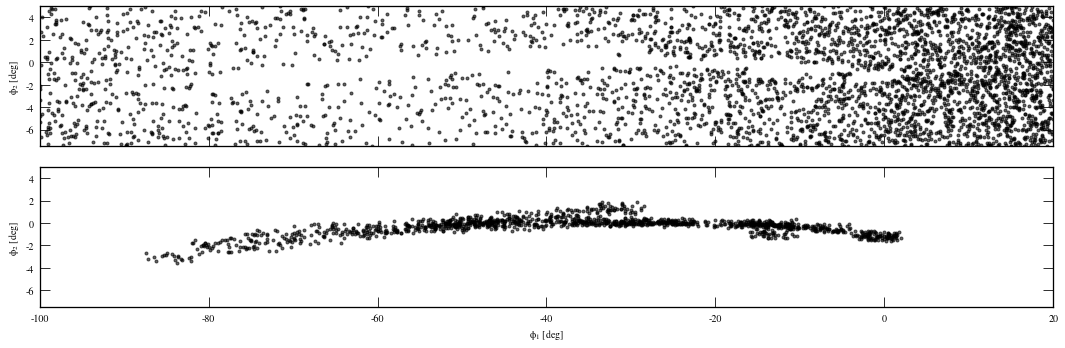

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5), sharex=True, sharey=True)

for ax, mask in zip(axes, [low_prob_mask, high_prob_mask]):
    ax.plot(phi1[mask], phi2[mask], 
            marker='o', linewidth=0, ms=3,
            linestyle='none', alpha=0.6, c='k')

# phi1_grid = np.linspace(-100, 20, 256)
# ax.plot(phi1_grid, phi2_poly(phi1_grid), marker='', color='tab:red')

ax.set_xlim(-100, 20)
ax.set_ylim(-7.5, 5)

axes[0].set_ylabel(r'$\phi_2$ [deg]')
axes[1].set_ylabel(r'$\phi_2$ [deg]')
axes[1].set_xlabel(r'$\phi_1$ [deg]')

fig.tight_layout()
fig.set_facecolor('w')

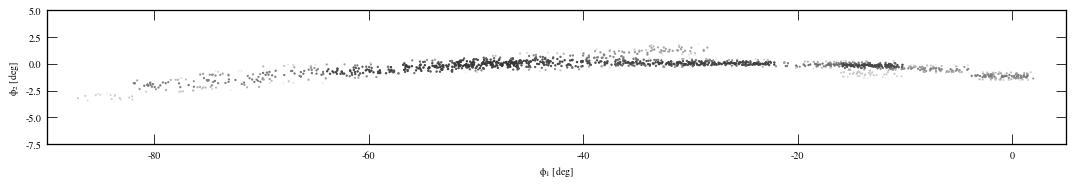

In [17]:
plt.figure(figsize=(15,10))
plt.scatter(phi1, phi2, s=pmem*2, c=pmem, cmap=mpl.cm.binary, vmin=0.5, vmax=1.1)
plt.gca().set_aspect('equal')

plt.xlim(-90,5)
plt.ylim(-7.5,5)
plt.ylabel(r'$\phi_2$ [deg]')
plt.xlabel(r'$\phi_1$ [deg]')

plt.tight_layout()

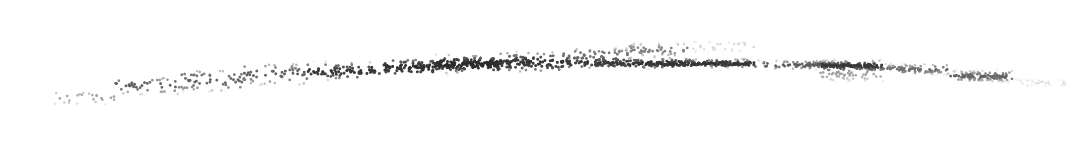

In [18]:
plt.figure(figsize=(15,10))
plt.scatter(phi1, phi2, s=pmem*4, c=pmem, cmap=mpl.cm.binary, vmin=0.35, vmax=1.1)
plt.gca().set_aspect('equal')

plt.xlim(-90,7)
plt.ylim(-7.5,5)
plt.axis('off')

plt.tight_layout()
plt.savefig('../plots/vis_light.png', dpi=200)

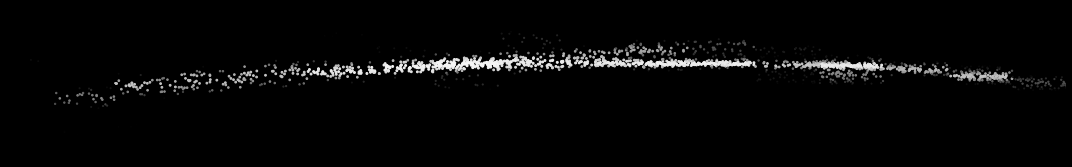

In [19]:
fig = plt.figure(figsize=(15,10), facecolor='k')
plt.scatter(phi1, phi2, s=pmem*4, c=pmem, cmap=mpl.cm.gray, vmin=0.2, vmax=1)
plt.gca().set_aspect('equal')

plt.xlim(-90,7)
plt.ylim(-7.5,5)
plt.axis('off')

plt.tight_layout()
fig.savefig('../plots/vis_dark.png', dpi=200, facecolor=fig.get_facecolor(), edgecolor='none')